# 1. Introduction

In [3]:
import pandas as pd
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}

for file in data_files:
    d=pd.read_csv(f"schools/{file}")
    key_name=file.replace(".csv","")
    data[key_name]=d
    
print(data)

all_survey=pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding="windows-1252")

d75_survey=pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding="windows-1252")

survey=pd.concat([all_survey, d75_survey], axis=0)

print(survey.head())

survey["DBN"]=survey["dbn"]

survey_fields=["DBN", 
               "rr_s", 
               "rr_t", 
               "rr_p", 
               "N_s", 
               "N_t", 
               "N_p", 
               "saf_p_11", 
               "com_p_11", 
               "eng_p_11",
               "aca_p_11", 
               "saf_t_11", 
               "com_t_11", 
               "eng_t_11", 
               "aca_t_11", 
               "saf_s_11", 
               "com_s_11", 
               "eng_s_11", 
               "aca_s_11", 
               "saf_tot_11",
               "com_tot_11",
               "eng_tot_11", 
               "aca_tot_11"]

survey=survey.loc[:,survey_fields]

data["survey"]=survey

print(data["survey"])

def pad_csd(num):
    return str(num).zfill(2)

data["hs_directory"]["DBN"]=data["hs_directory"]["dbn"]

data["class_size"]["padded_csd"]=data["class_size"]["CSD"].apply(pad_csd)

data["class_size"]["DBN"]=data["class_size"]["padded_csd"]+data["class_size"]["SCHOOL CODE"]

print(data["class_size"].head())

cols=["SAT Math Avg. Score","SAT Critical Reading Avg. Score","SAT Writing Avg. Score"]

for col in cols:
    data["sat_results"][col] = pd.to_numeric(data["sat_results"][col], errors="coerce")
    
data["sat_results"]["sat_score"]=0

for col in cols:
    data["sat_results"]["sat_score"]+=data["sat_results"][col]

print(data["sat_results"]["sat_score"].head())

import re

def find_lat(string):
    coords = re.findall("\(.+\)", string)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat


data["hs_directory"]["lat"]=data["hs_directory"]["Location 1"].apply(find_lat)

print(data["hs_directory"]["lat"].head())

import re

def find_lon(string):
    coords=re.findall("\(.+\)", string)
    lat=coords[0].split(",")[1].replace(")","")
    return lat

data["hs_directory"]["lon"]=data["hs_directory"]["Location 1"].apply(find_lon)

print(data["hs_directory"]["lon"].head())

data["hs_directory"]["lat"]=pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"]=pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

print("Latitude Data", 
      data["hs_directory"]["lat"].head(), 
      "Longitude Data", 
      data["hs_directory"]["lon"].head(), 
      sep="\n")

class_size=data["class_size"]

class_size=class_size[class_size["GRADE "]=="09-12"]
class_size=class_size[class_size["PROGRAM TYPE"]=="GEN ED"]

print(class_size.head())

import numpy as np
import pandas as pd

class_size=class_size.groupby("DBN").agg(np.mean)

class_size=class_size.reset_index()

data["class_size"]=class_size

print(data["class_size"].head())

school_20112012=data["demographics"]["schoolyear"]==20112012

data["demographics"]=data["demographics"][school_20112012]

print(data["demographics"].head())

data["graduation"]=data["graduation"][data["graduation"]["Cohort"]=="2006"]

data["graduation"]=data["graduation"][data["graduation"]["Demographic"]=="Total Cohort"]

print(data["graduation"].head())

cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col]=pd.to_numeric(data["ap_2010"][col],errors="coerce")
    
    
print(data["ap_2010"][cols].dtypes)



combined = data["sat_results"]

combined=combined.merge(data["ap_2010"],how="left")

combined=combined.merge(data["graduation"],how="left")

print(combined.head())

print(combined.shape)

combined=combined.merge(data["class_size"],how="inner")

combined=combined.merge(data["demographics"],how="inner")

combined=combined.merge(data["survey"],how="inner")

combined=combined.merge(data["hs_directory"],how="inner")

print(combined.head())

print(combined.shape)

combined=combined.fillna(combined.mean())
combined=combined.fillna(0)

print(combined.head())

def first_two(string):
    return string[:2]

combined["school_dist"]=combined["DBN"].apply(first_two)

print(combined["school_dist"].head())

{'ap_2010':         DBN                                         SchoolName  \
0    01M448                       UNIVERSITY NEIGHBORHOOD H.S.   
1    01M450                             EAST SIDE COMMUNITY HS   
2    01M515                                LOWER EASTSIDE PREP   
3    01M539                     NEW EXPLORATIONS SCI,TECH,MATH   
4    02M296              High School of Hospitality Management   
..      ...                                                ...   
253  31R605                         STATEN ISLAND TECHNICAL HS   
254  32K545                      EBC-HS FOR PUB SERVICE (BUSH)   
255  32K552                          Academy of Urban Planning   
256  32K554               All City Leadership Secondary School   
257  32K556  Bushwick Leaders High School for Academic Exce...   

    AP Test Takers  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                39                49                                   10  
1                19                21    

      dbn    bn                      schoolname  d75 studentssurveyed  \
0  01M015  M015       P.S. 015 Roberto Clemente    0               No   
1  01M019  M019             P.S. 019 Asher Levy    0               No   
2  01M020  M020            P.S. 020 Anna Silver    0               No   
3  01M034  M034  P.S. 034 Franklin D. Roosevelt    0              Yes   
4  01M063  M063       P.S. 063 William McKinley    0               No   

   highschool                  schooltype  rr_s  rr_t  rr_p  ...  s_q14_2  \
0         0.0           Elementary School   NaN    88    60  ...      NaN   
1         0.0           Elementary School   NaN   100    60  ...      NaN   
2         0.0           Elementary School   NaN    88    73  ...      NaN   
3         0.0  Elementary / Middle School  89.0    73    50  ...      NaN   
4         0.0           Elementary School   NaN   100    60  ...      NaN   

   s_q14_3  s_q14_4  s_q14_5  s_q14_6  s_q14_7  s_q14_8  s_q14_9  s_q14_10  \
0      NaN      NaN 

Over the last two missions, we began investigating possible relationships between SAT scores and demographics. In order to do this, we acquired several data sets containing information about New York City public schools. We cleaned them, then combined them into a single data set named combined that we're now ready to analyze and visualize.

In this mission, we'll discover correlations, create plots, and then make maps. The first thing we'll do is find any correlations between any of the columns and sat_score. This will help us determine which columns might be interesting to plot out or investigate further. Afterwards, we'll perform more analysis and make maps using the columns we've identified.

# 2. Finding Correlations With the r Value

Correlations tell us how closely related two columns are. We'll be using the r value, also called Pearson's correlation coefficient, which measures how closely two sequences of numbers are correlated.

An r value falls between -1 and 1. The value tells us whether two columns are positively correlated, not correlated, or negatively correlated. The closer to 1 the r value is, the stronger the positive correlation between the two columns. The closer to -1 the r value is, the stronger the negative correlation (i.e., the more "opposite" the columns are). The closer to 0, the weaker the correlation. To learn more about r values, see the statistics course.

Because we're interested in exploring the fairness of the SAT, a strong positive or negative correlation between a demographic factor like race or gender and SAT score would be an interesting result meriting investigation. If men tended to score higher on the SAT, for example, that would indicate that the SAT is potentially unfair to women, and vice-versa.

We can use the pandas pandas.DataFrame.corr() method to find correlations between columns in a dataframe. The method returns a new dataframe where the index for each column and row is the name of a column in the original data set.

# 3. Finding Correlations With the r Value

In [7]:
correlations=combined.corr()

correlations=correlations["sat_score"]

print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# 4. Plotting Enrollment With the Plot() Accessor

Unsurprisingly, SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score, and sat_score are strongly correlated with sat_score.

We can also make some other observations:

* total_enrollment has a strong positive correlation with sat_score. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.
    * Other columns that are proxies for enrollment correlate similarly. These include total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS.
* Both the percentage of females (female_per) and number of females (female_num) at a school correlate positively with SAT score, whereas the percentage of males (male_per) and the number of males (male_num) correlate negatively. This could indicate that women do better on the SAT than men.
* Teacher and student ratings of school safety (saf_t_11, and saf_s_11) correlate with sat_score.
* Student ratings of school academic standards (aca_s_11) correlate with sat_score, but this does not hold for ratings from teachers and parents (aca_p_11 and aca_t_11).
* There is significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).
* The percentage of English language learners at the school (ell_percent, frl_percent) has a strong negative correlation with SAT scores.

Because enrollment seems to have such a strong correlation, let's make a scatterplot of total_enrollment vs sat_score. Each point in the scatterplot will represent a high school, so we'll be able to see if there are any interesting patterns.

We can plot columns in a dataframe using the pandas.DataFrame.plot() accessor on a dataframe. We can also specify a certain plot type. For example, df.plot.scatter(x="A", y="b") will create a scatterplot of columns A and B.

# 5. Plotting Enrollment With the Plot() Accessor

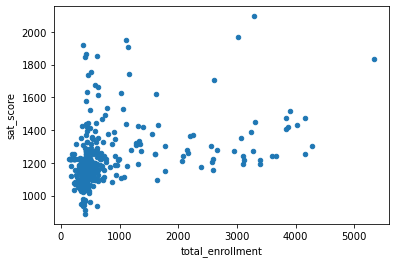

In [12]:
import matplotlib.pyplot as plt

combined.plot.scatter(x="total_enrollment",y="sat_score")

plt.show()

# 6. Exploring Schools With Low SAT Scores and Enrollment

In [22]:
low_enrollment=combined[combined["total_enrollment"]<1000]

low_enrollment=combined[combined["sat_score"]<1000]

print(low_enrollment["SCHOOL NAME"])

91                  INTERNATIONAL COMMUNITY HIGH SCHOOL
125                 ACADEMY FOR LANGUAGE AND TECHNOLOGY
126                     BRONX INTERNATIONAL HIGH SCHOOL
139               KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141               INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176    PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
179                       HIGH SCHOOL OF WORLD CULTURES
188                  BROOKLYN INTERNATIONAL HIGH SCHOOL
225       INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS
237                          IT TAKES A VILLAGE ACADEMY
253                           MULTICULTURAL HIGH SCHOOL
286              PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


It looks as though most of these small, low scoring high schools are international schools which could mean that the students don't speak English as a first language.

# 7. Plotting Language Learning Percentage

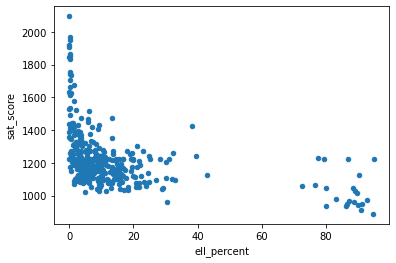

In [24]:
combined.plot.scatter(x="ell_percent",y="sat_score")

plt.show()

# 8. Calculating District-Level Statistics

In [29]:
import numpy as np

districts=combined.groupby("school_dist").agg(np.mean)

districts.reset_index(inplace=True)

print(districts.head())

  school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
0          01                       441.833333           473.333333   
1          02                       426.619092           444.186256   
2          03                       428.529851           437.997512   
3          04                       402.142857           416.285714   
4          05                       427.159915           438.236674   

   SAT Writing Avg. Score    sat_score  AP Test Takers   Total Exams Taken  \
0              439.333333  1354.500000       116.681090         173.019231   
1              424.832836  1295.638184       128.908454         201.516827   
2              426.915672  1293.443035       156.183494         244.522436   
3              405.714286  1224.142857       129.016484         183.879121   
4              419.666098  1285.062687        85.722527         115.725275   

   Number of Exams with scores 3 4 or 5  Total Cohort  CSD  ...  \
0                            135.8000

# 9. Next Steps

In this mission, we found correlations, created visualizations, and analyzed data district-by-district! Now we have all the tools we need to analyze the data in greater depth.

Along the way, we learned:

* How to find correlations, and what those correlations mean
* Why we should plot data out, rather than relying on the r value alone
* That ell_percent has a strong negative correlation with sat_score
* We now have the skills to analyze data sets and explain the quirks we find. These are essential skills for any data science professional.

Next, we'll use the skills and tools we've developed to analyze the New York City high school data more fully in a guided project.

